# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')


# b. MNIST Data Loader

In [4]:
def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.79MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 100kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:02<00:00, 783kB/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.52MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



# **1. PixelCNN**


# a. Training Function

In [36]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# b. Masked Convolution

In [221]:
class MaskedConv2d(nn.Conv2d):
    ##################
    ### Problem 2(a): Implement MaskedConv2d
    def __init__(self, in_channels,out_channels,kernel_size,padding=(0,0), mask_type='A'):
        super().__init__(in_channels, out_channels, kernel_size,padding=padding)
        ##创建一个[ker_height,ker_width]的mask
        self.mask=torch.zeros(kernel_size)
        h,w=self.mask.shape
        if mask_type=='A':
            self.mask[0:h//2,:]=1
            self.mask[h//2,0:w//2]=1
        else:
            self.mask[0:h//2,:]=1
            self.mask[h//2,0:w//2+1]=1
        
    def forward(self, x):
        self.weight.data=self.mask.to(device)*self.weight.data
        return super().forward(x)
    ##################


# c. Model

In [229]:
class PixelCNN(nn.Module):
    ##################
    ### Problem 2(b): Implement PixelCNN
    def __init__(self):
        super().__init__()
        self.conv1=MaskedConv2d(1, 16, kernel_size=(5,5), padding=2,mask_type='A')
        
        self.conv2=MaskedConv2d(in_channels=16, out_channels=32, kernel_size=(7,7),padding=3, mask_type='A')
        
        self.conv3=MaskedConv2d(in_channels=32, out_channels=64, kernel_size=(9,9),padding=4, mask_type='B')
        self.conv4=MaskedConv2d(in_channels=64, out_channels=32, kernel_size=(7,7),padding=3, mask_type='B')
        self.conv5=MaskedConv2d(in_channels=32, out_channels=16, kernel_size=(9,9),padding=4, mask_type='A')
        self.conv6=MaskedConv2d(in_channels=16, out_channels=8, kernel_size=(3,3),padding=1, mask_type='A')
        self.conv7=MaskedConv2d(in_channels=8, out_channels=1, kernel_size=(3,3),padding=1, mask_type='A')
        self.relu=torch.nn.ReLU()
        self.sig=torch.nn.Sigmoid()
    def forward(self, x):
        x=self.conv1(x)
        x=self.relu(x)
        x=self.conv2(x)
        x=self.relu(x)
        x=self.conv3(x)
        x=self.relu(x)
        x=self.conv4(x)
        x=self.relu(x)
        x=self.conv5(x)
        x=self.relu(x)
        x=self.conv6(x)
        x=self.relu(x)
        x=self.conv7(x)
        x=self.sig(x)
        return x
    ##################

# d. Training

In [232]:
##################
### Problem 2(c): Training
epochs = 100
model = PixelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train(train_loader, model, optimizer, epochs)
##################


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/100], Average Loss: 0.2509



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/100], Average Loss: 0.1445



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/100], Average Loss: 0.1367



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/100], Average Loss: 0.1329



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/100], Average Loss: 0.1306



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/100], Average Loss: 0.1289



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/100], Average Loss: 0.1274



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/100], Average Loss: 0.1264



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/100], Average Loss: 0.1255



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/100], Average Loss: 0.1247



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [11/100], Average Loss: 0.1240



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [12/100], Average Loss: 0.1232



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [13/100], Average Loss: 0.1228



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [14/100], Average Loss: 0.1221



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [15/100], Average Loss: 0.1217



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [16/100], Average Loss: 0.1212



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [17/100], Average Loss: 0.1210



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [18/100], Average Loss: 0.1204



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [19/100], Average Loss: 0.1203



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [20/100], Average Loss: 0.1200



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [21/100], Average Loss: 0.1196



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [22/100], Average Loss: 0.1194



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [23/100], Average Loss: 0.1190



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [24/100], Average Loss: 0.1187



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [25/100], Average Loss: 0.1187



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [26/100], Average Loss: 0.1183



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [27/100], Average Loss: 0.1180



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [28/100], Average Loss: 0.1179



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [29/100], Average Loss: 0.1177



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [30/100], Average Loss: 0.1174



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [31/100], Average Loss: 0.1172



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [32/100], Average Loss: 0.1171



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [33/100], Average Loss: 0.1169



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [34/100], Average Loss: 0.1168



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [35/100], Average Loss: 0.1165



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [36/100], Average Loss: 0.1165



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [37/100], Average Loss: 0.1164



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [38/100], Average Loss: 0.1162



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [39/100], Average Loss: 0.1160



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [40/100], Average Loss: 0.1160



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [41/100], Average Loss: 0.1159



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [42/100], Average Loss: 0.1157



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [43/100], Average Loss: 0.1156



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [44/100], Average Loss: 0.1155



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [45/100], Average Loss: 0.1154



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [46/100], Average Loss: 0.1153



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [47/100], Average Loss: 0.1153



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [48/100], Average Loss: 0.1150



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [49/100], Average Loss: 0.1151



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [50/100], Average Loss: 0.1149



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [51/100], Average Loss: 0.1148



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [52/100], Average Loss: 0.1148



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [53/100], Average Loss: 0.1148



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [54/100], Average Loss: 0.1146



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [55/100], Average Loss: 0.1146



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [56/100], Average Loss: 0.1145



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [57/100], Average Loss: 0.1144



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [58/100], Average Loss: 0.1144



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [59/100], Average Loss: 0.1143



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [60/100], Average Loss: 0.1142



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [61/100], Average Loss: 0.1141



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [62/100], Average Loss: 0.1141



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [63/100], Average Loss: 0.1139



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [64/100], Average Loss: 0.1140



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [65/100], Average Loss: 0.1139



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [66/100], Average Loss: 0.1137



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [67/100], Average Loss: 0.1138



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [68/100], Average Loss: 0.1138



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [69/100], Average Loss: 0.1136



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [70/100], Average Loss: 0.1137



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [71/100], Average Loss: 0.1137



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [72/100], Average Loss: 0.1134



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [73/100], Average Loss: 0.1135



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [74/100], Average Loss: 0.1135



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [75/100], Average Loss: 0.1134



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [76/100], Average Loss: 0.1133



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [77/100], Average Loss: 0.1133



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [78/100], Average Loss: 0.1132



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [79/100], Average Loss: 0.1133



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [80/100], Average Loss: 0.1132



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [81/100], Average Loss: 0.1131



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [82/100], Average Loss: 0.1131



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [83/100], Average Loss: 0.1130



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [84/100], Average Loss: 0.1131



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [85/100], Average Loss: 0.1130



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [86/100], Average Loss: 0.1130



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [87/100], Average Loss: 0.1130



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [88/100], Average Loss: 0.1127



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [89/100], Average Loss: 0.1128



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [90/100], Average Loss: 0.1128



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [91/100], Average Loss: 0.1128



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [92/100], Average Loss: 0.1128



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [93/100], Average Loss: 0.1127



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [94/100], Average Loss: 0.1126



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [95/100], Average Loss: 0.1127



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [96/100], Average Loss: 0.1126



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [97/100], Average Loss: 0.1125



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [98/100], Average Loss: 0.1126



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [99/100], Average Loss: 0.1125



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [100/100], Average Loss: 0.1124



# e. Evaluation (Reconstruction)

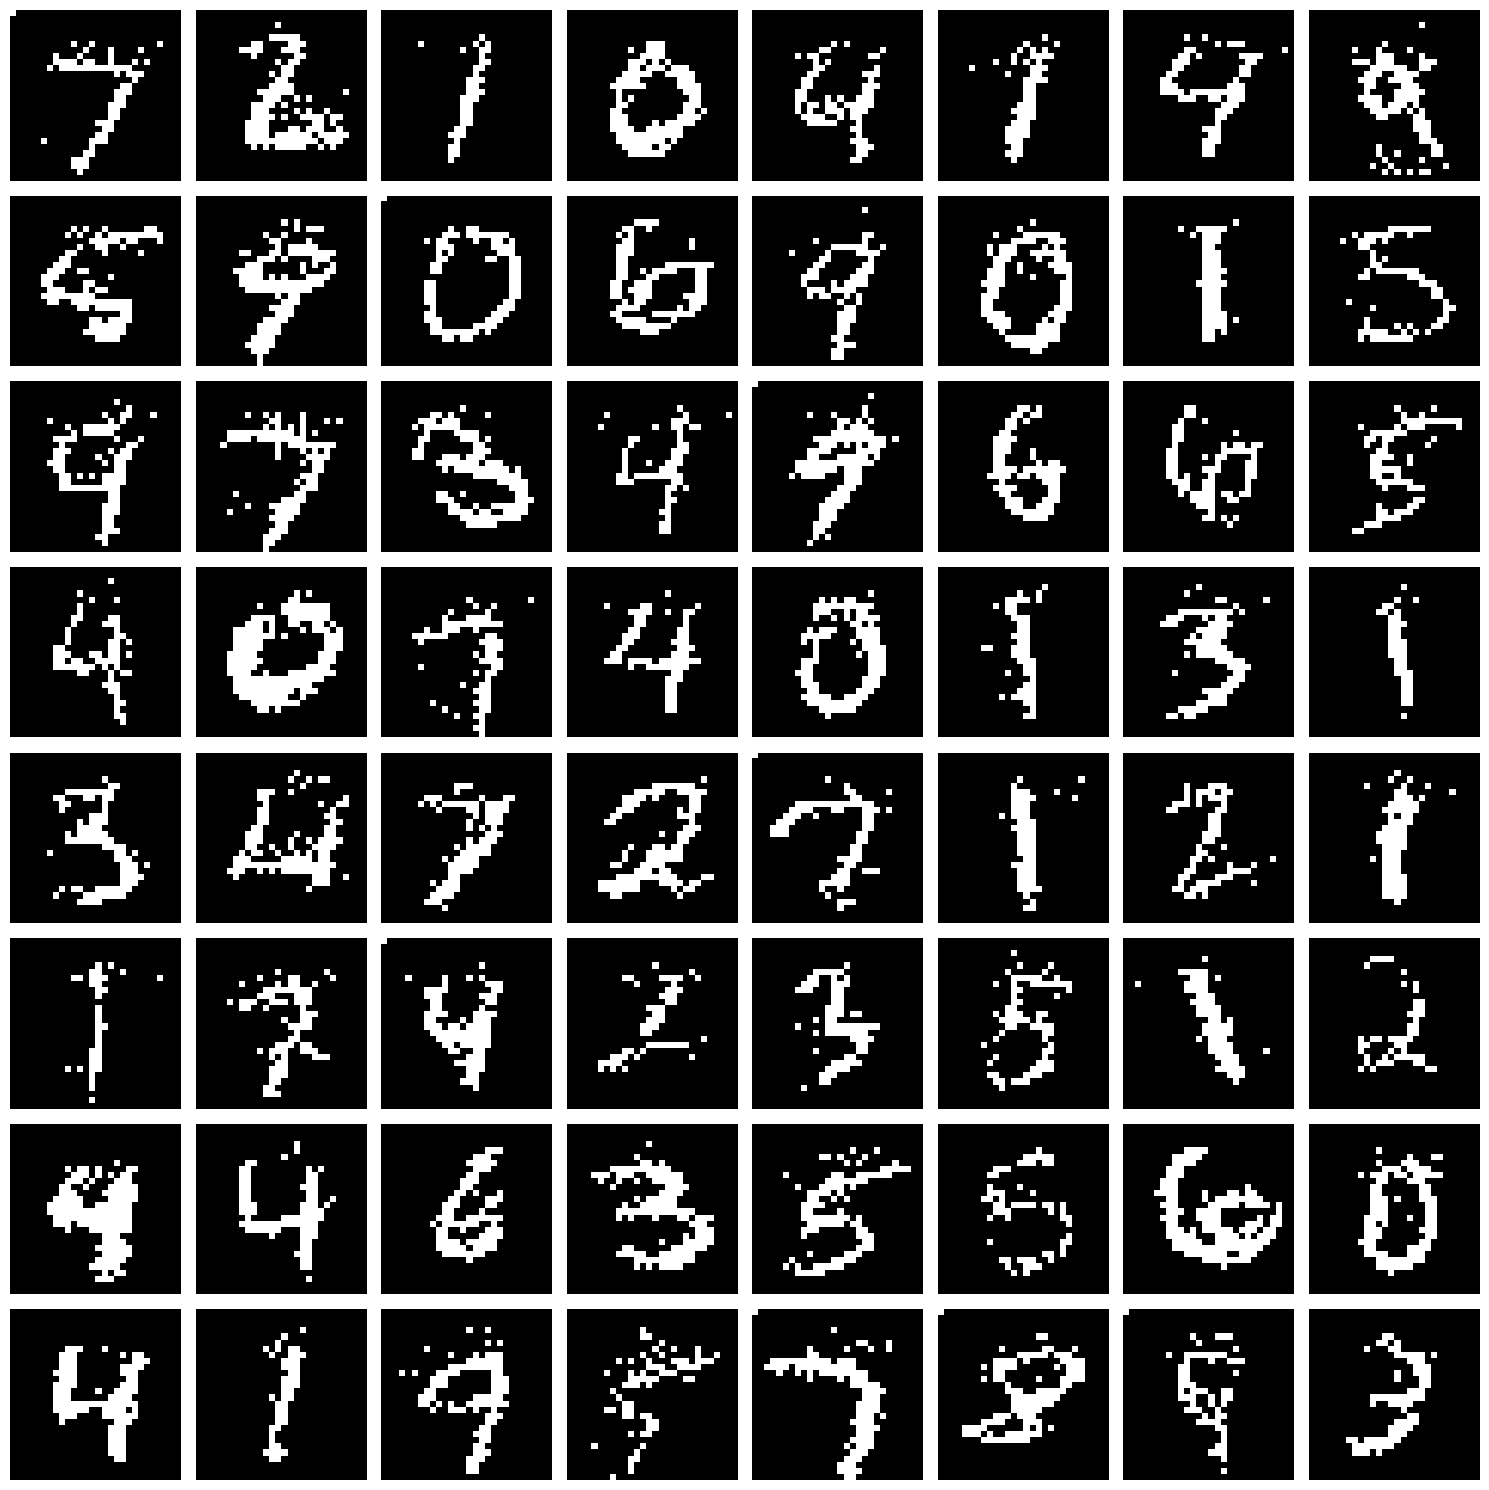

In [234]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      pred = model(images)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

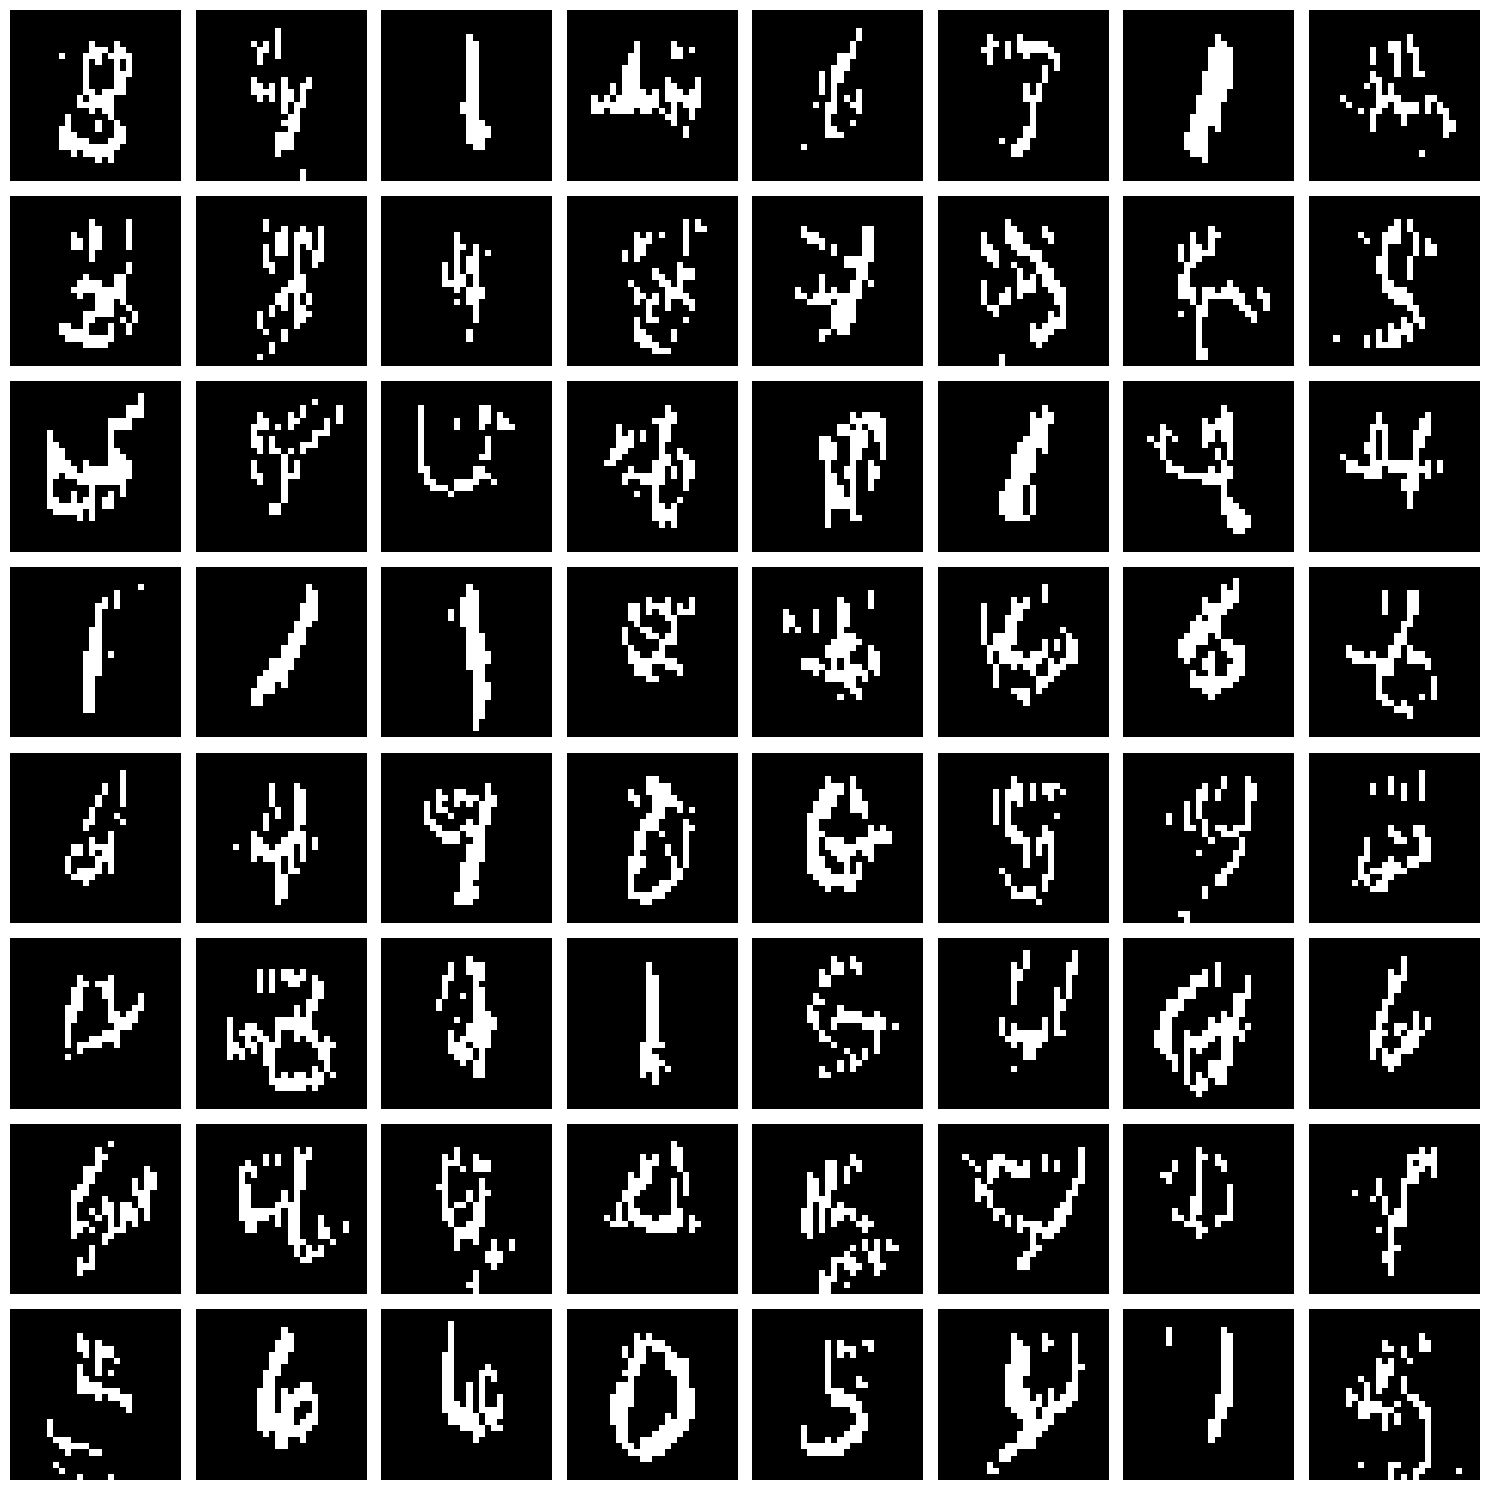

In [236]:
samples = torch.zeros(size=(64, 1, H, W)).to(device)
with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# **2. Conditional PixelCNN**


# a. Training Function

In [238]:
def train_cond(dataloader, model, optimizer, epochs, n_classes):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            labels = labels.to(device)
            tgt = images.clone()
            labels = F.one_hot(labels, num_classes=n_classes).float()
            pred = model(images, labels)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses

# b. Conditional Masked Convolution

In [256]:
class ConditionalMaskedConv2d(MaskedConv2d):
    ##################
    ### Problem 3(b): Implement ConditionalMaskedConv2d
    def __init__(self, num_classes,in_channels,out_channels,kernel_size,padding=(0,0), mask_type='A'):
        super().__init__(in_channels, out_channels, kernel_size,padding=padding)
        ##创建一个[ker_height,ker_width]的mask
        self.mask=torch.zeros(kernel_size).to(device)
        h,w=self.mask.shape
        if mask_type=='A':
            self.mask[0:h//2,:]=1
            self.mask[h//2,0:w//2]=1
        else:
            self.mask[0:h//2,:]=1
            self.mask[h//2,0:w//2+1]=1
        self.V=torch.nn.Linear(in_features=num_classes, out_features=out_channels,bias=False).to(device)
    def forward(self, x, class_condition):
        self.weight.data=self.weight.data*self.mask
        y=super().forward(x)
        
        z=self.V(class_condition).unsqueeze(-1).unsqueeze(-1)
        
        return y+z
    ##################

# c. Model

In [259]:
class ConditionalPixelCNN(nn.Module):
    ##################
    ### Problem 3(b): Implement ConditionalPixelCNN
    def __init__(self, num_classes):
        super().__init__()
        self.conv1=ConditionalMaskedConv2d(num_classes,1, 16, kernel_size=(5,5), padding=2,mask_type='A')
        
        self.conv2=ConditionalMaskedConv2d(num_classes,in_channels=16, out_channels=32, kernel_size=(7,7),padding=3, mask_type='A')
        
        self.conv3=ConditionalMaskedConv2d(num_classes,in_channels=32, out_channels=64, kernel_size=(9,9),padding=4, mask_type='B')
        self.conv4=ConditionalMaskedConv2d(num_classes,in_channels=64, out_channels=32, kernel_size=(7,7),padding=3, mask_type='B')
        self.conv5=ConditionalMaskedConv2d(num_classes,in_channels=32, out_channels=16, kernel_size=(9,9),padding=4, mask_type='A')
        self.conv6=ConditionalMaskedConv2d(num_classes,in_channels=16, out_channels=8, kernel_size=(3,3),padding=1, mask_type='A')
        self.conv7=ConditionalMaskedConv2d(num_classes,in_channels=8, out_channels=1, kernel_size=(3,3),padding=1, mask_type='A')
        self.relu=torch.nn.ReLU()
        self.sig=torch.nn.Sigmoid()
    def forward(self, x, class_condition):
        x=self.conv1(x,class_condition)
        x=self.relu(x)
        x=self.conv2(x,class_condition)
        x=self.relu(x)
        x=self.conv3(x,class_condition)
        x=self.relu(x)
        x=self.conv4(x,class_condition)
        x=self.relu(x)
        x=self.conv5(x,class_condition)
        x=self.relu(x)
        x=self.conv6(x,class_condition)
        x=self.relu(x)
        x=self.conv7(x,class_condition)
        x=self.sig(x)
        return x
    ##################

# d. Training

In [264]:
##################
epochs = 100
### Problem 3(c): Training
n_classes = 10
model = ConditionalPixelCNN(n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train_cond(train_loader, model, optimizer, epochs, n_classes)
##################


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/100], Average Loss: 0.2132



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/100], Average Loss: 0.1253



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/100], Average Loss: 0.1182



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/100], Average Loss: 0.1147



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/100], Average Loss: 0.1128



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/100], Average Loss: 0.1112



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/100], Average Loss: 0.1099



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/100], Average Loss: 0.1091



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/100], Average Loss: 0.1083



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/100], Average Loss: 0.1078



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [11/100], Average Loss: 0.1072



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [12/100], Average Loss: 0.1066



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [13/100], Average Loss: 0.1062



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [14/100], Average Loss: 0.1059



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [15/100], Average Loss: 0.1055



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [16/100], Average Loss: 0.1051



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [17/100], Average Loss: 0.1049



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [18/100], Average Loss: 0.1045



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [19/100], Average Loss: 0.1044



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [20/100], Average Loss: 0.1040



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [21/100], Average Loss: 0.1039



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [22/100], Average Loss: 0.1039



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [23/100], Average Loss: 0.1035



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [24/100], Average Loss: 0.1033



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [25/100], Average Loss: 0.1031



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [26/100], Average Loss: 0.1030



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [27/100], Average Loss: 0.1029



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [28/100], Average Loss: 0.1028



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [29/100], Average Loss: 0.1025



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [30/100], Average Loss: 0.1025



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [31/100], Average Loss: 0.1024



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [32/100], Average Loss: 0.1022



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [33/100], Average Loss: 0.1021



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [34/100], Average Loss: 0.1020



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [35/100], Average Loss: 0.1019



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [36/100], Average Loss: 0.1018



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [37/100], Average Loss: 0.1017



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [38/100], Average Loss: 0.1015



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [39/100], Average Loss: 0.1015



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [40/100], Average Loss: 0.1014



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [41/100], Average Loss: 0.1013



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [42/100], Average Loss: 0.1012



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [43/100], Average Loss: 0.1011



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [44/100], Average Loss: 0.1011



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [45/100], Average Loss: 0.1009



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [46/100], Average Loss: 0.1010



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [47/100], Average Loss: 0.1008



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [48/100], Average Loss: 0.1008



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [49/100], Average Loss: 0.1008



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [50/100], Average Loss: 0.1006



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [51/100], Average Loss: 0.1007



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [52/100], Average Loss: 0.1005



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [53/100], Average Loss: 0.1005



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [54/100], Average Loss: 0.1004



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [55/100], Average Loss: 0.1003



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [56/100], Average Loss: 0.1003



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [57/100], Average Loss: 0.1003



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [58/100], Average Loss: 0.1002



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [59/100], Average Loss: 0.1002



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [60/100], Average Loss: 0.1000



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [61/100], Average Loss: 0.1001



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [62/100], Average Loss: 0.1000



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [63/100], Average Loss: 0.1000



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [64/100], Average Loss: 0.1000



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [65/100], Average Loss: 0.0998



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [66/100], Average Loss: 0.0998



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [67/100], Average Loss: 0.0998



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [68/100], Average Loss: 0.0997



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [69/100], Average Loss: 0.0998



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [70/100], Average Loss: 0.0996



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [71/100], Average Loss: 0.0996



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [72/100], Average Loss: 0.0995



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [73/100], Average Loss: 0.0995



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [74/100], Average Loss: 0.0994



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [75/100], Average Loss: 0.0994



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [76/100], Average Loss: 0.0995



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [77/100], Average Loss: 0.0994



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [78/100], Average Loss: 0.0993



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [79/100], Average Loss: 0.0992



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [80/100], Average Loss: 0.0992



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [81/100], Average Loss: 0.0992



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [82/100], Average Loss: 0.0992



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [83/100], Average Loss: 0.0991



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [84/100], Average Loss: 0.0991



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [85/100], Average Loss: 0.0991



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [86/100], Average Loss: 0.0990



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [87/100], Average Loss: 0.0990



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [88/100], Average Loss: 0.0990



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [89/100], Average Loss: 0.0989



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [90/100], Average Loss: 0.0989



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [91/100], Average Loss: 0.0989



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [92/100], Average Loss: 0.0988



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [93/100], Average Loss: 0.0987



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [94/100], Average Loss: 0.0988



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [95/100], Average Loss: 0.0988



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [96/100], Average Loss: 0.0987



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [97/100], Average Loss: 0.0987



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [98/100], Average Loss: 0.0986



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [99/100], Average Loss: 0.0987



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [100/100], Average Loss: 0.0985



# e. Evaluation (Reconstruction)

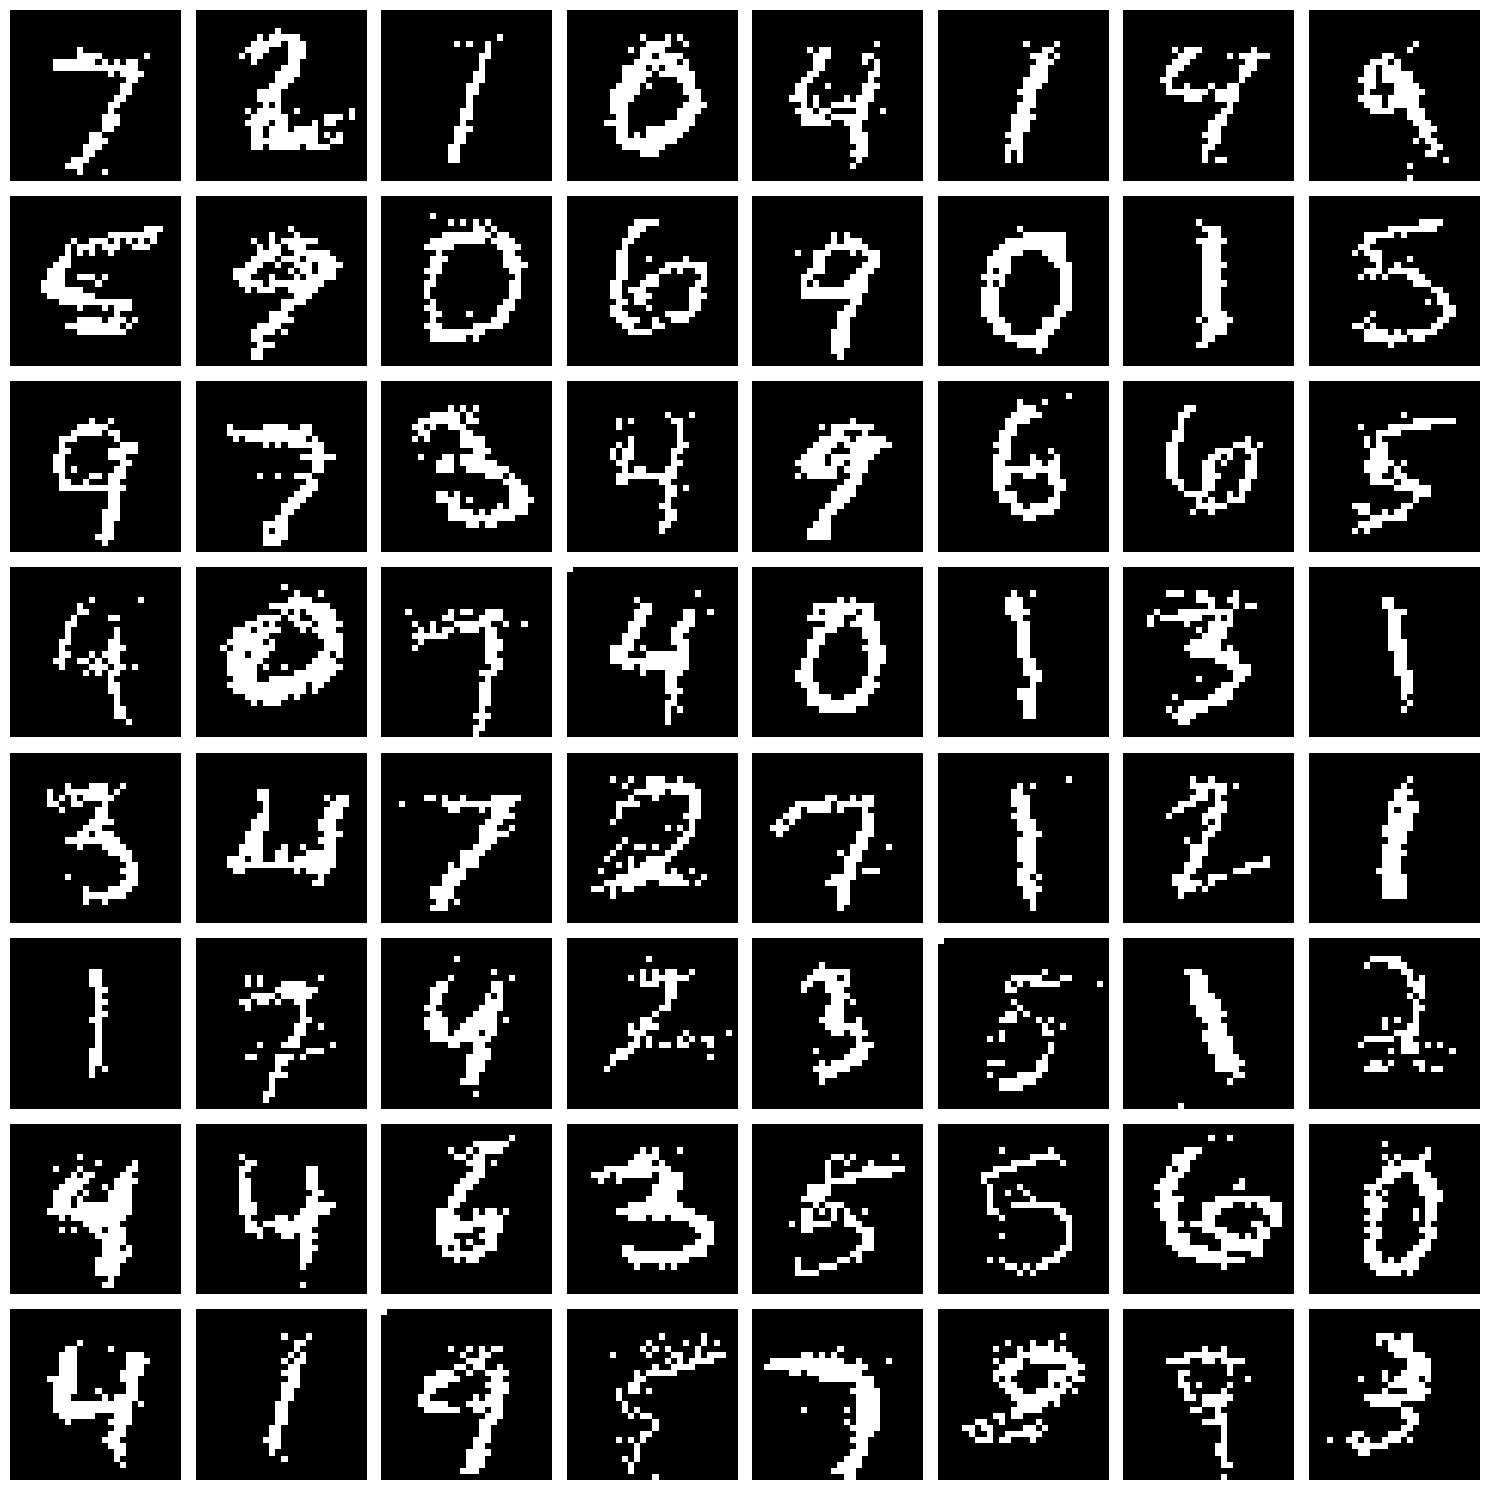

In [267]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      labels = F.one_hot(labels, num_classes=n_classes).float()
      pred = model(images, labels)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

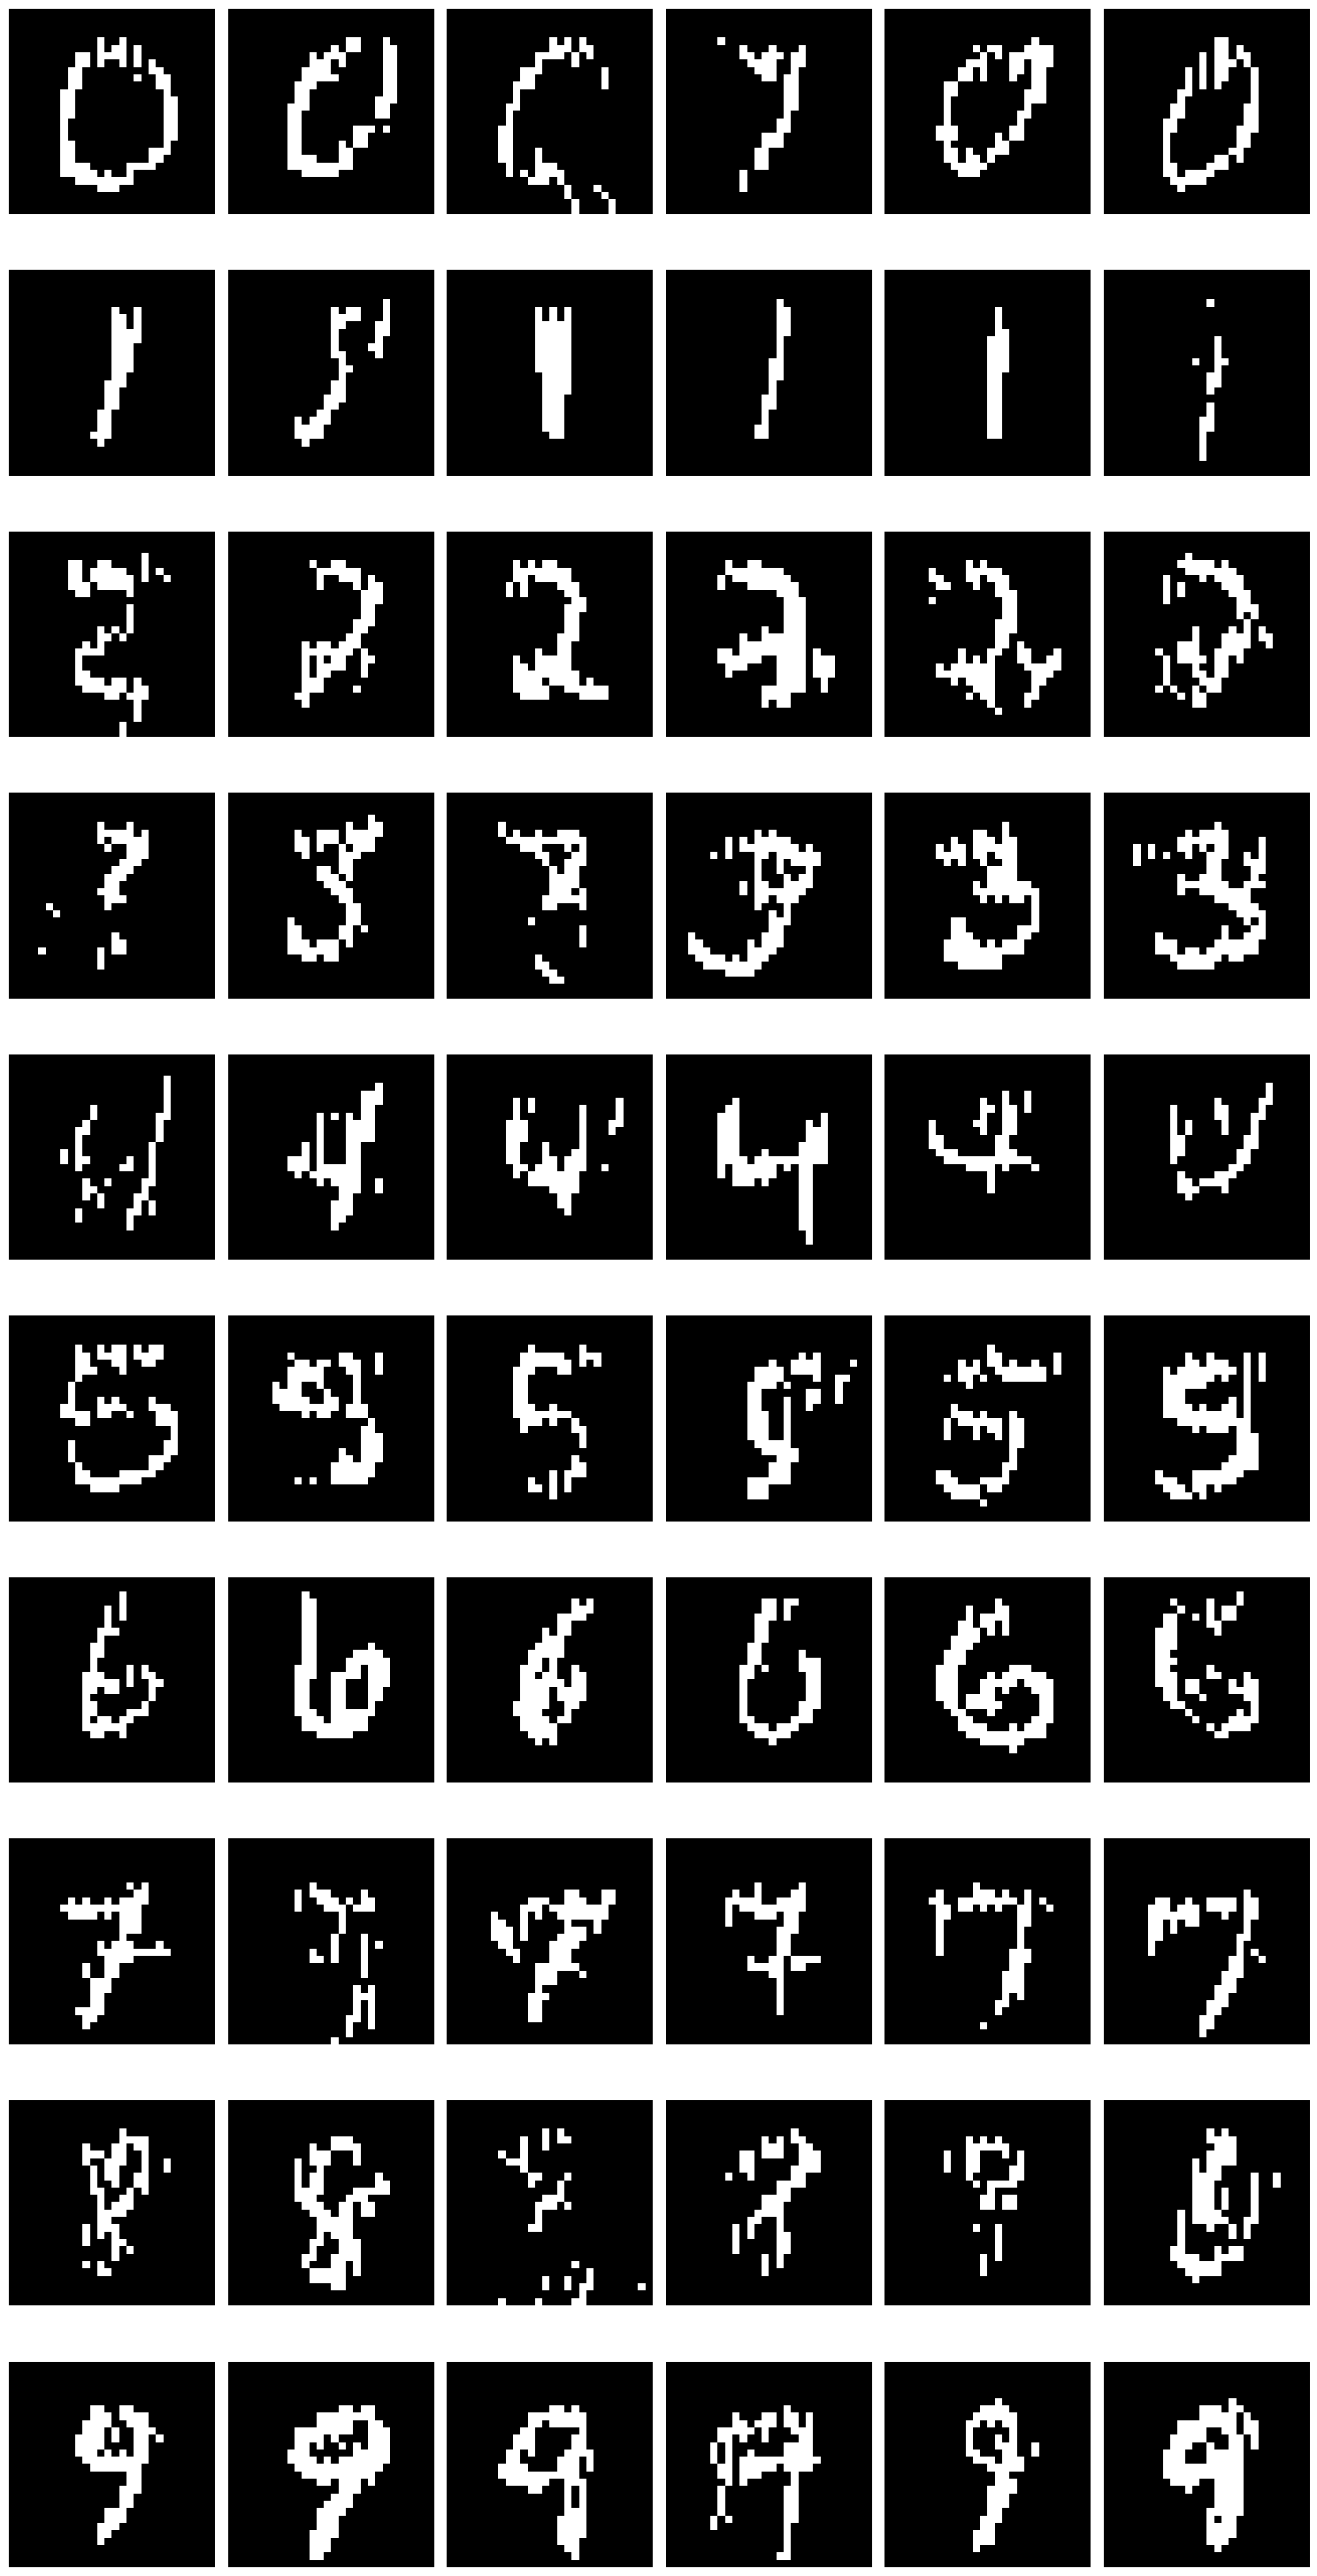

In [274]:
samples = torch.zeros(size=(60, 1, H, W)).to(device)
sample_classes = np.sort(np.array([np.arange(n_classes)] * 6).flatten())
sample_classes = F.one_hot(torch.LongTensor(sample_classes), num_classes=n_classes).to(device).float()

with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples, sample_classes)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(10, 6, figsize=(15, 30))

for i in range(60):
    sample = samples[i]
    row, col = divmod(i, 6)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()